## 1. Gather

In [1]:
import pandas as pd
import numpy as np
import json

### 1a. Load Flat Files

In [2]:
twitter = pd.read_csv('twitter-archive-enhanced.csv')
image = pd.read_csv('image-predictions-3.tsv', sep = "\t")

### 1b. Load Twitter API and JSON file

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

Convert.txt file line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count

In [3]:
with open('tweet-json.txt', 'r') as file:
    tweet_json = pd.read_json(file, lines=True)
    
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [4]:
tweet_json = tweet_json[['id','favorite_count','retweet_count']]
tweet_json.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853


## 2. Assess

In [5]:
twitter

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [6]:
pd.set_option('display.max_colwidth', -1)

In [7]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
twitter.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1632,684460069371654144,NaN,NaN,2016-01-05 19:42:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jeph. He's a Western Sagittarius Dookmarriot. Frightened by leaf. Caught him off guard. 10/10 calm down Jeph https://t.co/bicyOV6lju,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684460069371654144/photo/1,10,10,Jeph,None,None,None,None
1716,680206703334408192,NaN,NaN,2015-12-25 02:01:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I hope everyone enjoys this picture as much as I do. This is Toby. 12/10 https://t.co/vHnu1g9EJm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680206703334408192/photo/1,12,10,Toby,None,None,None,None
458,817908911860748288,NaN,NaN,2017-01-08 01:40:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Looks like he went cross-eyed trying way too hard to use the force. 12/10 \nhttps://t.co/bbuKxk0fM8,NaN,NaN,NaN,https://twitter.com/micahgrimes/status/817902080979599361,12,10,None,None,None,None,None
1366,702671118226825216,NaN,NaN,2016-02-25 01:47:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Rambo &amp; Kiwi. Rambo's the pup with the sharp toes &amp; rad mohawk. One stays woke while one sleeps. 10/10 for both https://t.co/MpH1Fe9LhZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702671118226825216/photo/1,10,10,Rambo,None,None,None,None
1660,683078886620553216,NaN,NaN,2016-01-02 00:14:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we see a nifty leaping pupper. Feet look deadly. Sad that the holidays are over. 9/10 undeniably huggable https://t.co/ny8mnXhGOW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683078886620553216/photo/1,9,10,None,None,None,pupper,None
1444,696713835009417216,NaN,NaN,2016-02-08 15:14:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Trevith. He's a Swiss Mountain Roadwoof. Breeze too powerful. 9/10 stay strong pupper https://t.co/6J8Ibwy1X6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/696713835009417216/photo/1,9,10,Trevith,None,None,pupper,None
2252,667801013445750784,NaN,NaN,2015-11-20 20:25:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",OMIGOD 12/10 https://t.co/SVMF4Frf1w,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667801013445750784/photo/1,12,10,None,None,None,None,None
603,798628517273620480,NaN,NaN,2016-11-15 20:47:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,6.675094e+17,4.196984e+09,2015-11-20 01:06:48 +0000,"https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://twitter.com/dog_rates/status/667509364010450944/photo/1",12,10,None,None,None,None,None
1868,675166823650848770,NaN,NaN,2015-12-11 04:14:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Arnold. He broke his leg saving a handicapped child from a forest fire. True hero. 10/10 inspirational dog https://t.co/bijCeHeX4C,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675166823650848770/photo/1,10,10,Arnold,None,None,None,None
328,833722901757046785,NaN,NaN,2017-02-20 17:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bronte. She's fairly h*ckin aerodynamic. Also patiently waiting for mom to make her a main character. 13/10 would be an honor to pet https://t.co/w1MQWO2PET,NaN,NaN,NaN,"https://

In [9]:
twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
twitter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [11]:
twitter.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [12]:
twitter[twitter['name'].str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog

In [13]:
image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [14]:
image.p3_dog.value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

In [15]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


### 2a. Quality

#### Enchanced twitter archive
- Clean the Rating data accuracy. To ensure that the rating is the accurately extracted from the tweet.
- Clean the Dog stage accuracy. To ensure that the stage is the accurately extracted from the tweet.
- Non dog name found under the dog name column. To covert these to null.
- Remove retweets from the data set, to include only original tweet hence no repetition.
- Remove replies from the data set, to include only original tweet hence no repetition.
- Tweet_id is in integer data type, should be string data type. Not numeric in nature
- Rating denomination is not consistent throughout the data, this is hard to benchmark to across the population data.
- Remove columns that are not required


### Image Prediction
- tweet_id is in integer data type, should be string data type. Not numeric in nature


#### Tweet_json
- id is in integer data type, should be string data type. Not numeric in nature
- Rename the id header to match the header in the other two files

### Combined file
- Remove entries/tweets that are not dog

### 2b. Tidiness
#### Enchanced twitter archive
- Combine the two columns (rating_numberator and rating_denominator) information into one column as Rating Score as one attribute.

### All files
- Merging all the 3 files into a masterdataframe


## 3. Clean

In [17]:
twitter_clean = twitter.copy()

### Twitter Archive Clean

- Clean the rating data accuracy

Define:
Extract the rating numerator and denominator number from the tweet, column 'text'
    

In [18]:
#Code:

twitter_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

rating = twitter_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']
twitter_clean['rating_numerator'] = rating['rating_numerator'].astype(float)
twitter_clean['rating_denominator'] = rating['rating_denominator'].astype(float)

In [19]:
#test:

twitter_clean.rating_numerator.value_counts()

12.00      558
11.00      464
10.00      461
13.00      351
9.00       158
8.00       102
7.00       55 
14.00      54 
5.00       35 
6.00       32 
3.00       19 
4.00       17 
2.00       9  
1.00       9  
0.00       2  
420.00     2  
9.75       2  
15.00      2  
960.00     1  
84.00      1  
24.00      1  
17.00      1  
13.50      1  
143.00     1  
121.00     1  
80.00      1  
182.00     1  
165.00     1  
45.00      1  
204.00     1  
1776.00    1  
666.00     1  
99.00      1  
11.27      1  
11.26      1  
88.00      1  
144.00     1  
9.50       1  
20.00      1  
44.00      1  
60.00      1  
50.00      1  
Name: rating_numerator, dtype: int64

In [20]:
twitter_clean.rating_denominator.value_counts()

10.0     2333
11.0     3   
50.0     3   
20.0     2   
80.0     2   
110.0    1   
0.0      1   
15.0     1   
7.0      1   
150.0    1   
16.0     1   
120.0    1   
2.0      1   
170.0    1   
70.0     1   
130.0    1   
90.0     1   
40.0     1   
Name: rating_denominator, dtype: int64

- Clean the Dog stage accuracy

Define:
Extract the word "doggo, floofer, pupper or puppo" from the tweet - column 'text' and create a new column for Dog Stage

In [21]:
#Code:

twitter_clean['dog_stage'] = twitter_clean['text'].str.extract('(doggo|floofer|pupper|puppo)', expand = True)

In [22]:
#Test:

twitter_clean.dog_stage.value_counts()

pupper     265
doggo      93 
puppo      37 
floofer    4  
Name: dog_stage, dtype: int64

In [23]:
twitter_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,None,None,None,None,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None,None,None,None,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,None,None,None,None,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,None,None,None,None,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,None,None,None,None,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,None,None,None,None,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13.0,10.0,Jax,None,None,None,None,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13.0,10.0,None,None,None,None,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/stat

- Remove entires with inappropriate dog names.

Define:
Replace the non dog names to null

In [24]:
#Code:

misname = twitter_clean.name.str.islower()
column_name = 'name'
twitter_clean.loc[misname,column_name]=np.nan

In [25]:
#Test:
twitter_clean[twitter_clean['name'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14.0,10.0,NaN,None,None,None,None,NaN
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14.0,10.0,NaN,None,None,pupper,None,pupper
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12.0,10.0,NaN,None,None,None,None,NaN
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12.0,10.0,NaN,None,None,None,None,NaN
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12.0,10.0,NaN,None,None,None,None,NaN
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10.0,10.0,NaN,None,None,None,None,NaN
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14.0,10.0,NaN,None,None,None,None,NaN
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11.0,10.0,NaN,None,None,None,None,NaN
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and For

- Remove retweets from the data set, to include only original tweet hence no repetition.

Define: Drop the retweets from the data set

In [26]:
#Code:

twitter_clean = twitter_clean[twitter_clean['retweeted_status_id'].isnull()]

In [27]:
#Test:

twitter_clean.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

- Remove replies from the data set, to include only original tweet hence no repetition.

Define: Drop the replies tweets from the data set

In [28]:
#Code:

twitter_clean = twitter_clean[twitter_clean['in_reply_to_status_id'].isnull()]

In [29]:
#Test:

twitter_clean.in_reply_to_status_id.value_counts()

Series([], Name: in_reply_to_status_id, dtype: int64)

- Tweet_id is in integer data type, should be string data type. Not numeric in nature

Define: Convert tweet_ID from the various data source to object

In [30]:
#Code:

twitter_clean.tweet_id = twitter_clean.tweet_id.astype(str)

In [31]:
#Test:

twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null float64
rating_denominator            2097 non-null float64
name                          1993 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dog_stage                     353 n

- Rating denomination is not consistent throughout the data, this is hard to benchmark to across the population data.
- Combine the two columns (rating_numberator and rating_denominator) into one row - Rating Score as one attribute. (Tidiness)

Define:
Generate a new column with rating that is based on the ratio of the rating numerator over the rating denominator number.

In [32]:
#Code:

combined_rating = []

combined_rating = twitter_clean['rating_numerator']/ twitter_clean['rating_denominator']

twitter_clean['combined_rating'] = combined_rating



- Remove columns that are not required

Define:
Remove the old columns

In [33]:
#Code:
twitter_clean = twitter_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

In [34]:
#Test:

twitter_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,doggo,floofer,pupper,puppo,dog_stage,combined_rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,None,None,None,None,NaN,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,None,None,None,None,NaN,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,None,None,None,None,NaN,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,None,None,None,None,NaN,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,None,None,None,None,NaN,1.2


- Remove columns that are not required

Define:
Remove the columns (doggo, floofer, pupper, puppo) as we have new column to for dog stage

In [35]:
#Code:
twitter_clean = twitter_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [36]:
#Test:

twitter_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,name,dog_stage,combined_rating
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,Phineas,NaN,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,Tilly,NaN,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,Archie,NaN,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,Darla,NaN,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",Franklin,NaN,1.2


### Image Prediction Clean


In [37]:
image_clean = image.copy()

- tweet_id is in integer data type, should be string data type. Not numeric in nature

Define: Change data type to string

In [38]:
#code:
image_clean.tweet_id = image_clean.tweet_id.astype(str)

In [39]:
#test
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


- Remove entries/tweets that are not dog

Define: Filter for false in P1_dog, p2_dog and p3_dog and img_num is 1. Assuming that if img_num is not 1, it would be a dog picture hence we pick this two criteria to remove the entries that are not dog.

In [40]:
#code:
image_clean = image_clean.drop(image_clean[(image_clean.p1_dog == False) & (image_clean.p2_dog == False) & (image_clean.p3_dog == False) &(image_clean.p1 == '1')].index)


In [41]:
#test:
check = (image_clean.p1_dog == False) & (image_clean.p2_dog == False) & (image_clean.p3_dog == False) &(image_clean.p1 == '1')
check.value_counts()

False    2075
dtype: int64

### Tweet_json clean


- id is in integer data type, should be string data type. Not numeric in nature

Define: Change data type to string

In [42]:
#code:
tweet_json.id = tweet_json.id.astype(str)

In [43]:
#test
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null object
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


- Rename the id header to match the header in the other two files

Define: rename the id header to tweet_id

In [44]:
#code:
tweet_json = tweet_json.rename(columns={'id': 'tweet_id'})

In [45]:
#test
tweet_json.head(1)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853


### Combine All File Tidiness

- Merging all the 3 files into a masterdataframe

Define: Combine the 3 files using the tweet_id or id

In [46]:
#code:

twitter_archive_0 = pd.merge(twitter_clean, image_clean, on=['tweet_id'], how='left')
twitter_archive_master = pd.merge(tweet_json ,twitter_archive_0,  on=['tweet_id'], how='left')

In [47]:
#test
twitter_archive_master

,tweet_id,favorite_count,retweet_count,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,39467,8853,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,33819,6514,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,25461,4328,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,42908,8964,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,41048,9774,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,20562,3261,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,12041,2158,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,56848,16716,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,28226,4429,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,32467,7711,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying internat

### Remove entries/tweets that are not dog
Define: Filter for false in P1_dog and remove the entries

In [48]:
#code:
twitter_archive_master = twitter_archive_master.drop(twitter_archive_master[(twitter_archive_master.p1_dog == False)].index)

In [49]:
#test:
check = (twitter_archive_master.p1_dog == False)
check.value_counts()

False    1846
Name: p1_dog, dtype: int64

In [50]:
twitter_archive_master

,tweet_id,favorite_count,retweet_count,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1,892177421306343426,33819,6514,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,25461,4328,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
4,891327558926688256,41048,9774,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,20562,3261,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,12041,2158,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,56848,16716,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,28226,4429,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,32467,7711,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,NaN,NaN,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
10,890006608113172480,31166,7624,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,NaN,NaN,...,1.0,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
11,889880896479866881,28268,5156,NaN,NaN,2017-07-25 16:11:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""n

### Output wrangled data file 

In [51]:
twitter_archive_master.to_csv("twitter_archive_master.csv")

## 4. Analyse and visualise

In [52]:
df = pd.read_csv('twitter_archive_master.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1846 entries, 0 to 1845
Data columns (total 27 columns):
Unnamed: 0                    1846 non-null int64
tweet_id                      1846 non-null int64
favorite_count                1846 non-null int64
retweet_count                 1846 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1589 non-null object
source                        1589 non-null object
text                          1589 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null float64
expanded_urls                 1586 non-null object
name                          1513 non-null object
dog_stage                     267 non-null object
combined_rating               1589 non-null float64
jpg_url                       1463 non-null object
img_num                       1463 non-n

### Insight 1 - Name of the highest rating score dog

In [54]:
df.max()

Unnamed: 0                    2353              
tweet_id                      892177421306343426
favorite_count                132810            
retweet_count                 79515             
in_reply_to_status_id         NaN               
in_reply_to_user_id           NaN               
retweeted_status_id           NaN               
retweeted_status_user_id      NaN               
retweeted_status_timestamp    NaN               
combined_rating               3.42857           
img_num                       4                 
p1_conf                       0.999956          
p1_dog                        True              
p2_conf                       0.467678          
p2_dog                        True              
p3_conf                       0.273419          
p3_dog                        True              
dtype: object

Based on the combined rating, the highest score is 3.42857

In [55]:
df[df.combined_rating == twitter_archive_master.combined_rating.max()].name

443    Sam
Name: name, dtype: object

The name of the dog is Sam.

### Insight 2 - What is the most common dog name

In [56]:
df.name.value_counts()

None         428
Charlie      10 
Cooper       10 
Lucy         9  
Oliver       9  
Tucker       8  
Daisy        7  
Sadie        7  
Penny        7  
Winston      6  
Jax          6  
Koda         6  
Stanley      5  
Leo          5  
Lola         5  
Toby         5  
Rusty        5  
Oscar        5  
Bo           5  
Bella        5  
Sophie       4  
Bear         4  
Finn         4  
Brody        4  
Jeffrey      4  
Cassie       4  
Scout        4  
Scooter      4  
Dexter       4  
Larry        4  
            ..  
Barney       1  
Bobbay       1  
Jim          1  
Herb         1  
Autumn       1  
Pilot        1  
Heinrich     1  
Willy        1  
Mabel        1  
Willow       1  
Rover        1  
Stefan       1  
Dobby        1  
Brandi       1  
Willem       1  
Venti        1  
Shikha       1  
Jockson      1  
Kobe         1  
Misty        1  
Curtis       1  
Rambo        1  
Schnitzel    1  
Suki         1  
Mosby        1  
Snoopy       1  
Katie        1  
Fwed         1

Charlie and Lucy are the most common dog names in the data.

### Insight 3 - Lowest rating dog type

In [57]:
df.min()

Unnamed: 0                    1                 
tweet_id                      666020888022790149
favorite_count                0                 
retweet_count                 0                 
in_reply_to_status_id         NaN               
in_reply_to_user_id           NaN               
retweeted_status_id           NaN               
retweeted_status_user_id      NaN               
retweeted_status_timestamp    NaN               
combined_rating               0.2               
img_num                       1                 
p1_conf                       0.0443334         
p1_dog                        True              
p2_conf                       2.33591e-05       
p2_dog                        False             
p3_conf                       2.1609e-07        
p3_dog                        False             
dtype: object

In [58]:
df[df.combined_rating == 0.2]

,Unnamed: 0,tweet_id,favorite_count,retweet_count,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
978,1163,722974582966214656,4493,1764,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,...,1.0,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True
1446,1762,678424312106393600,5916,2880,NaN,NaN,2015-12-20 03:58:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz,NaN,...,1.0,Maltese_dog,0.759945,True,toy_poodle,0.101194,True,Shih-Tzu,0.056037,True


They are the Great Dane and Maltese dog that had the lowest rating score.

### Visualisation - Rating vs Retweet count

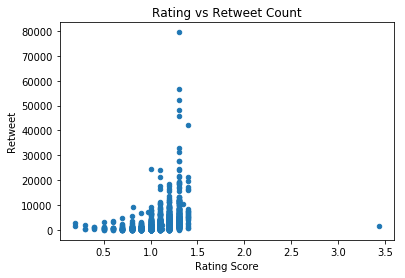

In [59]:
import matplotlib.pyplot as plt
% matplotlib inline

df.plot(x='combined_rating',y='retweet_count',kind='scatter');

plt.title('Rating vs Retweet Count') 
plt.xlabel('Rating Score') 
plt.ylabel('Retweet');

We noted a positive correlation that the higher the rating score, the higher number of retweets. The rating score of near 3.5 is probably an outlier in the population.